In [100]:
import numpy as np
import cv2 as cv
import skimage.io
import matplotlib.pyplot as plt
import os
import keras
from scipy import ndimage

In [2]:
data_base_path = os.path.join(os.pardir, 'project')
data_folder = 'data/frame'

# Load image
data_path = os.path.join(data_base_path, data_folder)

frames = []

for i in range(42):
    frame = skimage.io.imread(os.path.join(data_path, 'frame'+str(i)+'.jpeg'))
    frames.append(frame)

In [4]:
data_path = os.path.join(data_base_path, 'data')

operator = skimage.io.imread(os.path.join(data_path, 'original_operators.png'))

In [5]:
operator.shape

(316, 1736, 4)

In [6]:
frames = np.asarray(frames)
frames.shape

(42, 480, 720, 3)

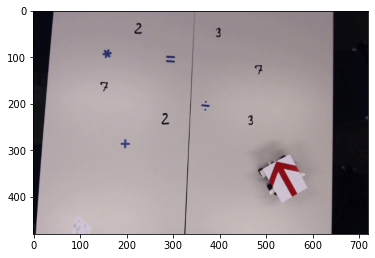

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(frames[0])
plt.show()

In [8]:
crop = frames[0][270:300, 180:210]

#binarization
gray = cv.cvtColor(crop, cv.COLOR_BGR2GRAY)
gray[gray<127] = 0
gray[gray>=127] = 1

In [9]:
crop = frames[0][220:248, 272:300]

#binarization
gray = cv.cvtColor(crop, cv.COLOR_BGR2GRAY)
gray[gray<127] = 0
gray[gray>=127] = 1


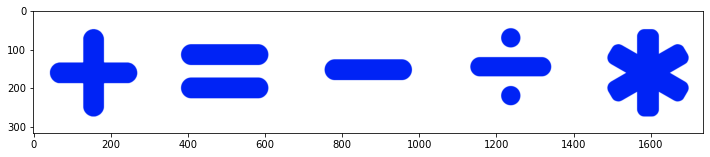

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(operator[:,:,:])
plt.show()

In [11]:
plus = operator[16:316, 0:300, :]
egal = operator[:, 350:650,:]
minus = operator[:, 700:1000,:]
div = operator[:, 1080:1380,:]
times = operator[:, 1450:1750,:]

operators = [plus, minus, div, times, egal]

In [12]:
plus.shape

(300, 300, 4)

In [37]:
img = div

print('Original Dimensions : ',img.shape)
 
dim = (28, 28)
# resize image
resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
img = resized[:,:,0]

Original Dimensions :  (316, 300, 4)
Resized Dimensions :  (28, 28, 4)


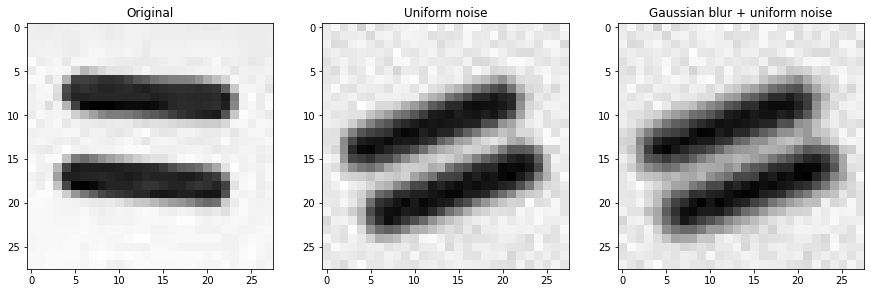

In [580]:
times_pos = (80, 145)
plus_pos = (273, 184) 
div_pos = (192, 357)
equal_pos = (92, 282)
size = 28

pos = equal_pos
img = egal


dim = (size, size)
# resize image
resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
 
img = resized[:,:,0]


img = ndimage.rotate(img, np.random.randint(360), reshape=False, mode='constant', cval=255, order=5, prefilter=False)
T = np.concatenate([np.identity(2), np.random.uniform(low=-2, high=2, size=(2,1))], axis=1)
img = cv.warpAffine(img, T, img.shape, borderValue=255)

noise = np.random.normal(0,10,(28,28))
g_blur = cv.GaussianBlur(img, (3, 3), 10, 10)
g_blur = g_blur + noise
unif_blur = img + noise

img = frames[0][pos[0]:pos[0]+size, pos[1]:pos[1]+size]
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)


fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(unif_blur, cmap='gray')
ax[1].set_title('Uniform noise')
ax[2].imshow(g_blur, cmap='gray')
ax[2].set_title('Gaussian blur + uniform noise')
plt.show()

In [604]:
dataset = []

for img in [plus, minus, div, times, egal]:
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    resized = cv.resize(gray, (size, size), interpolation = cv.INTER_AREA)

    for i in range(10_000):
        size = 28
        rotated = ndimage.rotate(resized, np.random.randint(360), reshape=False, mode='constant', cval=255, order=5, prefilter=False)
        T = np.concatenate([np.identity(2), np.random.uniform(low=-2, high=2, size=(2,1))], axis=1)
        translated = cv.warpAffine(rotated, T, rotated.shape, borderValue=255)

        noise = np.random.normal(0,15,(28,28))
        g_blur = cv.GaussianBlur(translated, (3, 3), 10, 10)
        out = g_blur + noise
        
        dataset.append(out)
        
dataset = np.array(dataset)
print(dataset.shape)

(50000, 28, 28)


In [605]:
with open('../../data/dataset.npy', 'wb') as f:
    np.save(f, dataset)

In [40]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [41]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 53s 884us/step - loss: 0.2439 - accuracy: 0.9257 - val_loss: 0.0516 - val_accuracy: 0.9824
Epoch 2/3
60000/60000 [==============================] - 55s 911us/step - loss: 0.0830 - accuracy: 0.9746 - val_loss: 0.0405 - val_accuracy: 0.9864
Epoch 3/3
60000/60000 [==============================] - 58s 962us/step - loss: 0.0633 - accuracy: 0.9815 - val_loss: 0.0333 - val_accuracy: 0.9885
Test loss: 0.033280715271484226
Test accuracy: 0.9884999990463257


In [77]:
gray = np.reshape(gray, (1,28,28,1))
prediction = model.predict(gray) #new prediction on the preprocessed extracted image
prediction #percentage of prediction for each digit classes

array([[1.15621615e-05, 6.44434690e-02, 9.26116526e-01, 2.72195291e-04,
        1.19876664e-03, 8.87037822e-06, 7.86286220e-03, 7.53758923e-06,
        7.77086389e-05, 5.72809427e-07]], dtype=float32)

In [78]:
prediction.argmax() #model predict a 2 which is right

2